In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import efficientnet.keras as efn

base_model = efn.EfficientNetB4(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.summary()

Using TensorFlow backend.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 351236    
Total params: 18,025,052
Trainable params: 351,236
Non-trainable params: 17,673,816
_________________________________________________________________


In [2]:
import pandas as pd

df = pd.read_csv('input/four_class.csv')
df['file_name']=df['image_id']+'.jpg'
df=df[['file_name','dx','lesion_id']]
#df.head()

from sklearn.model_selection import train_test_split
label_dataframe=df.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(df, label_dataframe, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(23, 2)
(89, 2)
(13, 2)


In [3]:
train=pd.concat([X_train,y_train],axis=1)
train.head()
val=pd.concat([X_val,y_val],axis=1)
val.head()
test=pd.concat([X_test,y_test],axis=1)
test.head()

,file_name,lesion_id,dx
18,0 (27).jpg,12,fungal_infection
42,0 (58).jpg,26,fungal_infection
36,0 (52).jpg,24,papule
76,0 (109).jpg,45,dermatitis
53,0 (77).jpg,33,papule


In [4]:
from sklearn import preprocessing
vle = preprocessing.LabelEncoder()
vle.fit(val['dx'])
label=vle.transform(val['dx']) 
print(list(vle.classes_))
val['label']=label
print(train.head())
le_name_mapping = dict(zip(vle.classes_, vle.transform(vle.classes_)))
print(le_name_mapping)

trle = preprocessing.LabelEncoder()
trle.fit(train['dx'])
label=trle.transform(train['dx']) 
print(list(trle.classes_))
train['label']=label
print(train.head())
le_name_mapping = dict(zip(trle.classes_, trle.transform(trle.classes_)))
print(le_name_mapping)

le = preprocessing.LabelEncoder()
le.fit(test['dx'])
label=le.transform(test['dx']) 
print(list(le.classes_))
test['label']=label
print(test.head())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['acne', 'dermatitis', 'fungal_infection', 'papule']
       file_name  lesion_id                dx
54    0 (78).jpg         33            papule
111  0 (164).jpg         66              acne
6     0 (14).jpg          6  fungal_infection
22    0 (31).jpg         15  fungal_infection
59    0 (83).jpg         35        dermatitis
{'acne': 0, 'dermatitis': 1, 'fungal_infection': 2, 'papule': 3}
['acne', 'dermatitis', 'fungal_infection', 'papule']
       file_name  lesion_id                dx  label
54    0 (78).jpg         33            papule      3
111  0 (164).jpg         66              acne      0
6     0 (14).jpg          6  fungal_infection      2
22    0 (31).jpg         15  fungal_infection      2
59    0 (83).jpg         35        dermatitis      1
{'acne': 0, 'dermatitis': 1, 'fungal_infection': 2, 'papule': 3}
['acne', 'dermatitis', 'fungal_infection', 'papule']
      file_name  lesion_id                dx  label
18   0 (27).jpg         12  fungal_infection      2
42   0 (58).j

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
rescale = 1./255,
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.4, # Randomly zoom image 
shear_range=0.2,
width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=True)  # randomly flip images)


In [6]:
train_data= train_generator.flow_from_dataframe(
dataframe=train,
x_col="file_name",
y_col="dx",
batch_size=4,
seed=311,
directory="input/test",
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 89 validated image filenames belonging to 4 classes.


In [7]:
test_generator=ImageDataGenerator(
rescale = 1./255)
test_data= test_generator.flow_from_dataframe(
dataframe=test,
x_col="file_name",
y_col="dx",
seed=45,
directory="input/test",
shuffle=False,
batch_size=1,
class_mode=None,
target_size=(224,224))

Found 13 validated image filenames.


In [8]:
val_data=test_generator.flow_from_dataframe(
dataframe=val,
directory="input/test",
x_col="file_name",
y_col="dx",
batch_size=1,
seed=45,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 23 validated image filenames belonging to 4 classes.


In [9]:
from sklearn.utils import class_weight
import numpy as np

class_weight = np.round(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train['dx']))
print(class_weight)
print(train_data.class_indices)
print(val_data.class_indices)
print(train['dx'].value_counts())

[1. 1. 1. 2.]
{'acne': 0, 'dermatitis': 1, 'fungal_infection': 2, 'papule': 3}
{'acne': 0, 'dermatitis': 1, 'fungal_infection': 2, 'papule': 3}
fungal_infection    41
dermatitis          18
acne                17
papule              13
Name: dx, dtype: int64


In [10]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                    patience=4, 
                                    verbose=1, 
                                    factor=0.2, 
                                    min_lr=0.0001)

In [11]:
model.compile(optimizer=SGD(lr=0.001, nesterov=True),loss="categorical_crossentropy",metrics=["accuracy"])
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=30,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/30
22/22 [==============================] - 15s 692ms/step - loss: 1.9318 - accuracy: 0.3294 - val_loss: 3.7446 - val_accuracy: 0.0870
Epoch 2/30
22/22 [==============================] - 8s 383ms/step - loss: 2.0834 - accuracy: 0.3412 - val_loss: 3.7583 - val_accuracy: 0.1304
Epoch 3/30
22/22 [==============================] - 8s 365ms/step - loss: 2.0400 - accuracy: 0.4353 - val_loss: 2.7269 - val_accuracy: 0.3043
Epoch 4/30
22/22 [==============================] - 8s 358ms/step - loss: 2.1275 - accuracy: 0.3882 - val_loss: 2.5201 - val_accuracy: 0.1739
Epoch 5/30
22/22 [==============================] - 8s 348ms/step - loss: 1.7268 - accuracy: 0.4471 - val_loss: 2.9438 - val_accuracy: 0.2609
Epoch 6/30
22/22 [==============================] - 8s 344ms/step - loss: 1.9361 - accuracy: 0.3765 - val_loss: 1.6350 - val_accuracy: 0.1739
Epoch 7/30
22/22 [==============================] - 8s 348ms/step - loss: 2.0534 - accuracy: 0.4000 - val_loss: 2.8191 - val_accuracy: 0.1739

Epoc

In [12]:
base_model.trainable = True
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17673816  
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 351236    
Total params: 476,436
Trainable params: 351,236
Non-trainable params: 125,200
_________________________________________________________________


In [23]:
model.compile(optimizer=SGD(lr=0.0001, nesterov=True),loss="categorical_crossentropy",metrics=["accuracy"])
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=15,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/15
22/22 [==============================] - 33s 1s/step - loss: 1.0401 - accuracy: 0.6235 - val_loss: 0.3510 - val_accuracy: 0.3478
Epoch 2/15
22/22 [==============================] - 9s 401ms/step - loss: 0.9065 - accuracy: 0.7176 - val_loss: 0.2891 - val_accuracy: 0.3478
Epoch 3/15
22/22 [==============================] - 9s 408ms/step - loss: 1.1261 - accuracy: 0.5765 - val_loss: 0.2742 - val_accuracy: 0.4348
Epoch 4/15
22/22 [==============================] - 9s 408ms/step - loss: 0.8017 - accuracy: 0.7059 - val_loss: 0.2189 - val_accuracy: 0.3913
Epoch 5/15
22/22 [==============================] - 9s 410ms/step - loss: 1.1122 - accuracy: 0.5682 - val_loss: 0.2855 - val_accuracy: 0.3478
Epoch 6/15
22/22 [==============================] - 9s 398ms/step - loss: 0.8639 - accuracy: 0.6585 - val_loss: 0.2289 - val_accuracy: 0.3913
Epoch 7/15
22/22 [==============================] - 9s 402ms/step - loss: 1.1144 - accuracy: 0.6118 - val_loss: 0.1740 - val_accuracy: 0.4783
Epoch 8/

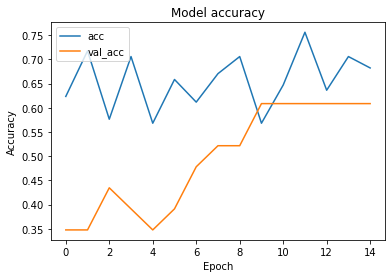

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

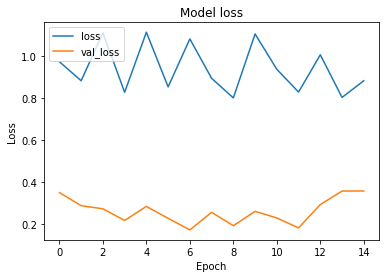

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [26]:
val_data.reset()
predictions = model.predict_generator(val_data, steps=val_data.samples/val_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)
print(y_pred)
ground_truth=val_data.classes

23/23 [==============================] - 4s 178ms/step
[1 3 2 2 3 2 0 2 1 3 2 2 2 2 1 2 2 2 3 1 0 1 2]


In [27]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['papule','acne', 'fungal_infection', 'dermatitis']
print(classification_report(val_data.classes, y_pred, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

          papule       0.00      0.00      0.00         3
            acne       0.60      0.60      0.60         5
fungal_infection       0.75      1.00      0.86         9
      dermatitis       0.50      0.33      0.40         6

        accuracy                           0.61        23
       macro avg       0.46      0.48      0.46        23
    weighted avg       0.55      0.61      0.57        23



In [28]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

13/13 [==============================] - 1s 92ms/step


In [29]:
print(y_pred)
ground_truth=test['label']
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['papule','acne', 'fungal_infection', 'dermatitis']
print(classification_report(ground_truth, y_pred, target_names=target_names))

[2 2 3 2 3 0 3 3 3 3 2 2 2]
Classification Report
                  precision    recall  f1-score   support

          papule       1.00      0.33      0.50         3
            acne       0.00      0.00      0.00         3
fungal_infection       0.33      1.00      0.50         2
      dermatitis       0.83      1.00      0.91         5

        accuracy                           0.62        13
       macro avg       0.54      0.58      0.48        13
    weighted avg       0.60      0.62      0.54        13



In [30]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

13/13 [==============================] - 1s 91ms/step


In [31]:
ground_truth=test['label']
print('Confusion Matrix')
print(confusion_matrix(ground_truth, y_pred))

Confusion Matrix
[[1 0 1 1]
 [0 0 3 0]
 [0 0 2 0]
 [0 0 0 5]]


In [32]:
from keras.models import load_model

model.save('fine_four_class.h5')